In [1]:
##--------------------------------------------------------------------------------
## Summary : classify hand written digits using simple CNN,Pretty Tensor&use saver
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##--------------------------------------------------------------------------------

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import prettytensor as pt
import os

from sklearn.metrics import confusion_matrix

In [2]:
## Importing the handwritten data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
##Declaring constants
img_size = 28
img_shape = (img_size,img_size)
img_size_flat = img_size * img_size
num_classes = 10
batch_size = 100

trueLabelsTrain = np.array([label.argmax() for label in data.train.labels])
trueLabelsTest = np.array([label.argmax() for label in data.test.labels])
trueLabelsValidation = np.array([label.argmax() for label in data.validation.labels])

In [4]:
## Declaring function to plot images
def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #create a 3x3 subplot
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if predLabels==None:
            xlabel = 'True : '+str(trueLabels[i])
        else : 
            xlabel = 'True : '+str(trueLabels[i])+' Pred : '+str(predLabels[i])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
##lets write a function to print weights
def printConfMatrix(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)

##Function to print wrong examples    
def printExampleErrors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    plotImages(incorrectImages[0:9],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [6]:
##lets write a function to plot conv weights
def plotConvWeights(weights,inputChannel=0):
    ##find max and min of weights
    w_max = np.max(weights)
    w_min = np.min(weights)
    
    ##lets get number of weights to plot
    numFilters = weights.shape[3]
    
    ##lets get number of images per axis
    numGrids = math.ceil(math.sqrt(numFilters))
    
    (fig,axes) = plt.subplots(numGrids,numGrids)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ##Remove the axes where there are no filters
        if i<numFilters:
            image = weights[:,:,inputChannel,i]
            ax.imshow(image,vmax=w_max,vmin=w_min,interpolation='nearest', cmap='seismic')
            ax.set_xlabel('Filter : '+str(i))
        
            #remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

In [7]:
##lets create the graph 

##Input PlaceHolders
x = tf.placeholder(tf.float32,shape=[None,img_size_flat])
y_true = tf.placeholder(tf.float32,shape=[None,num_classes])

## We are passing the image to cnn so need to resize it 
x_image = tf.reshape(x,[-1,img_size,img_size,1])

##Pretty Tensor
x_pretty = pt.wrap(x_image)

##Model declaration
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred,loss = x_pretty.conv2d(kernel=5,depth=10,name='layer1').max_pool(kernel=2,stride=2).\
            conv2d(kernel=5,depth=24,name='layer2').max_pool(kernel=2,stride=2).\
            flatten().fully_connected(size=128,name='layerfc').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
    
            
## accuracy
correct = tf.equal(tf.argmax(y_pred,dimension=1),tf.argmax(y_true,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

##Optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [8]:
## Saver function to save best stopping. We are exploring early stopping here
saver = tf.train.Saver()
saveDir = 'savedState/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
savePath = os.path.join(saveDir, 'best_validation')    



In [9]:
##Lets write a function to get the weights from this pretty tensor

# Retrieve an existing variable named 'weights' in the scope
# with the given layer_name.
def getWeights(layerName):
    with tf.variable_scope(layerName,reuse=True):
        variable = tf.get_variable('weights')
        
    return variable

In [10]:
weights1 = getWeights('layer1')
weights2 = getWeights('layer2')

In [11]:
## lets start running the graph
session = tf.Session()
session.run(tf.global_variables_initializer())

def runOptimization(numIter):
    ## Initialize variables for accuracies.For early stopping we should stop at point
    ## where the testing accuracies don't improve.
    bestAccuracy = 0.0
    lastImprIter = 0
    maxIterWithOutImpr = 2
    curIteration = 0
    for i in range(0,numIter):
        curIteration = curIteration+1
        batchSize = 100
        startTime = time.time()
        numIterations = int(len(data.train.labels)/batchSize)
        
        for j in range(0,numIterations):
            [x_batch,y_batch] = data.train.next_batch(batch_size)
            
            feed = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict=feed)
            
        labelsTrain = session.run(y_pred,feed_dict={x:data.train.images,y_true:data.train.labels})
        labelsTest = session.run(y_pred,feed_dict={x:data.test.images,y_true:data.test.labels})
        w1 = session.run(weights1,feed_dict={x:data.train.images,y_true:data.train.labels})
        w2 = session.run(weights2,feed_dict={x:data.train.images,y_true:data.train.labels})
        
        accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
        accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        #if accuracy improves at least 0.1%
        if((accuracyTest-bestAccuracy)>=0.001):
            bestAccuracy = accuracyTest
            lastImprIter = curIteration
            ##Save the state
            saver.save(sess=session,save_path=savePath)
            isImproved = '*'
        else:
            isImproved = ''
        
        print('Iteration ',str(i),':-  ','Training accuracy : ',accuracyTrain*100,'  Testing accuracy : ',accuracyTest*100,str(isImproved))
        print('Time Taken : ',str(time.time()-startTime),'seconds')
        
        if(curIteration-lastImprIter>maxIterWithOutImpr):
            print('No improvements in testing accuracy for a while. Performing \'Early Stopping\'')
            break
            
    return labelsTrain,labelsTest,w1,w2

In [12]:
labelsTrain,labelsTest,w1,w2 = runOptimization(2)

Iteration  0 :-   Training accuracy :  96.025454998   Testing accuracy :  96.0699975491 *
Time Taken :  152.473042011261 seconds
Iteration  1 :-   Training accuracy :  98.7054526806   Testing accuracy :  98.6599981785 *
Time Taken :  162.69602060317993 seconds


In [13]:
printConfMatrix(np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

[[5372    2   17    0    1    3   31    2   11    5]
 [   0 6119   16    5    3    0    9   13   13    1]
 [   0    1 5438    8    3    1    5    7    4    3]
 [   2    0   24 5564    0   23    1    9   10    5]
 [   3   10    6    0 5207    0   19   16    6   40]
 [   1    0    3   12    0 4928   36    1    3    3]
 [   4    1    0    1    3    3 5404    0    1    0]
 [   0    7   25    5    5    0    0 5660    9    4]
 [   3   14   28   27    4   25   25    6 5241   16]
 [   6    5    4   21   12   13    2   25   11 5355]]


/home/srvv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


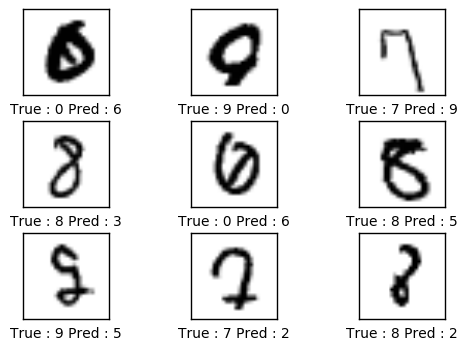

In [14]:
## lets print example errors
printExampleErrors(data.train.images,np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

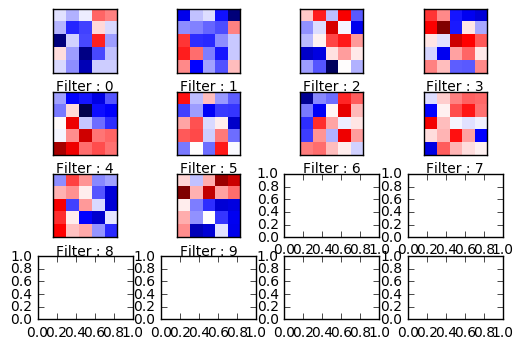

In [15]:
plotConvWeights(w1)

In [16]:
## Now lets run some more iterations
labelsTrain,labelsTest,w1,w2 = runOptimization(8)

Iteration  0 :-   Training accuracy :  99.0127265453   Testing accuracy :  98.7500011921 *
Time Taken :  161.65174555778503 seconds
Iteration  1 :-   Training accuracy :  99.0981817245   Testing accuracy :  98.7999975681 
Time Taken :  153.23062801361084 seconds
Iteration  2 :-   Training accuracy :  99.2399990559   Testing accuracy :  98.7699985504 
Time Taken :  142.9957160949707 seconds
Iteration  3 :-   Training accuracy :  99.412727356   Testing accuracy :  98.869997263 *
Time Taken :  145.62243938446045 seconds
Iteration  4 :-   Training accuracy :  99.3109107018   Testing accuracy :  98.7999975681 
Time Taken :  144.3142192363739 seconds
Iteration  5 :-   Training accuracy :  99.6745467186   Testing accuracy :  99.1299986839 *
Time Taken :  138.4845950603485 seconds
Iteration  6 :-   Training accuracy :  99.6527254581   Testing accuracy :  98.970001936 
Time Taken :  137.09514832496643 seconds
Iteration  7 :-   Training accuracy :  99.7963607311   Testing accuracy :  99.09999966

In [17]:
printConfMatrix(np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

[[5444    0    0    0    0    0    0    0    0    0]
 [   0 6169    0    0    1    0    3    5    1    0]
 [   0    0 5465    0    1    0    1    2    1    0]
 [   3    0    4 5620    0    4    0    1    1    5]
 [   0    2    0    0 5297    0    1    1    1    5]
 [   3    0    0    6    0 4969    7    0    2    0]
 [   4    0    0    0    2    1 5410    0    0    0]
 [   0    5    1    0    0    0    0 5707    0    2]
 [   2    4    4    0    0    0    2    1 5373    3]
 [   0    1    0    0    7    0    0   11    1 5434]]


/home/srvv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


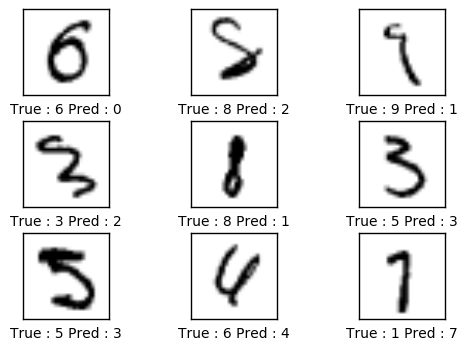

In [18]:
## lets print example errors
printExampleErrors(data.train.images,np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

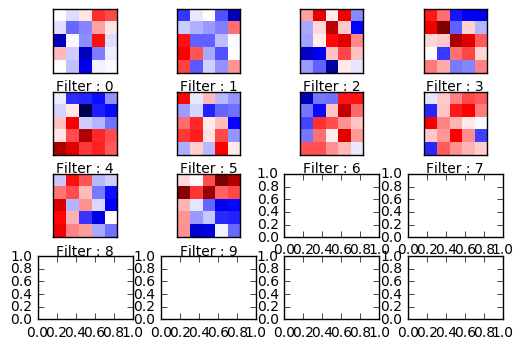

In [19]:
plotConvWeights(w1)

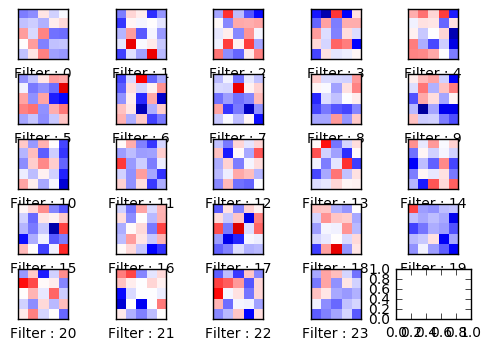

In [20]:
plotConvWeights(w2)

In [ ]:
##We can restore the session using the following command
saver.restore(sess=session, save_path=savePath)